In [9]:
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.figure import Figure
import numpy as np
from numpy.typing import NDArray
from typing import List, Union, Tuple
from matplotlib_sankey._utils import _clean_axis
from matplotlib_sankey._types import CurveType

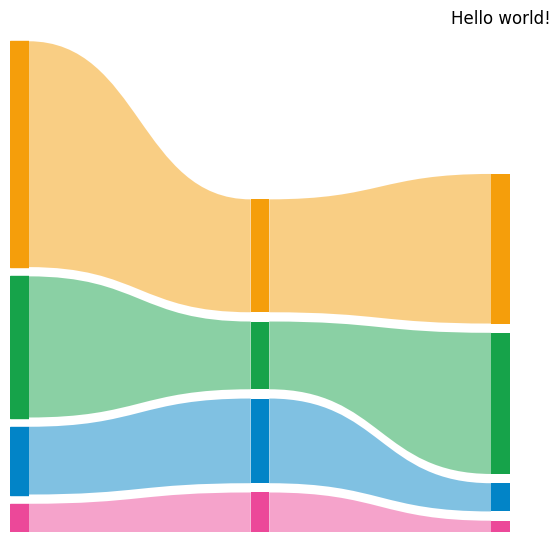

In [10]:
def sankey(
    data: NDArray,
    colors: Union[NDArray, List[str]],
    spacing: float = 0.2,
    frameon: bool = True,
    figsize: Tuple[int, int] = (5, 5),
    curve_type: CurveType = "curve4",
    alpha: float = 0.5,
    tight_layout: bool = False,
    max_scale: bool = False,
) -> Figure:
    """Plot sankey.

    Args:
        data (numpy.ndarray): Input data.
        colors (Union[NDArray, List[str]]): List of colors.
        spacing (float, optional): Spacing between column and ribbon patches. Defaults to `0.2`.
        frameon (bool, optional): Draw frame. Defaults to `True`.
        figsize (Tuple[int, int]): Size of figure. Defaults to `(5, 5)`.
        curve_type (Literal["curve3", "curve4", "line"], optional): Curve type ofo ribbon. Defaults to `"curve4"`.
        alpha (float, optional): Alpha of ribbons. Defaults to `0.5`.
        tight_layout (bool, optional): Use tight layout for figure. Defaults to `False`.
        max_scale (bool, optional): Scale values for overall maximum keep absolute differences in column height. Defaults to `False`.

    """
    # Max Scale data to 1
    scaled_data = [None] * len(data)
    scale_factor: NDArray

    if max_scale is True:
        scale_factor = np.array([data.sum(axis=1).max()] * len(data))
    else:
        scale_factor = data.sum(axis=1)

    for index, data_colum in enumerate(data):
        scaled_data[index] = data_colum / scale_factor[index]

    assert (
        np.array(scaled_data).shape == data.shape
    ), f"Scaled shape {scaled_data.shape} does not match input data {data.shape}"

    # Init figure and axes
    axes: List[Axes]

    fig, axes = plt.subplots(
        nrows=1,
        ncols=len(data) + len(data) - 1,
        sharey=True,
        width_ratios=[*([1, 12] * (len(data) - 1)), 1],
        frameon=frameon,
        figsize=figsize,
    )

    # Remove spacing
    fig.subplots_adjust(hspace=0, wspace=0)

    total_height = 1.0 + (len(colors) * spacing)

    # Draw columns on first axes
    axes[0] = _clean_axis(axes[0], frameon=False)
    axes[0].set_ylim(0.0, total_height)

    for index, size in enumerate(scaled_data[0]):
        rect = Rectangle(
            xy=(0, sum(scaled_data[0][:index]) + (index * spacing)), width=1, height=size, color=colors[index], zorder=1
        )
        axes[0].add_patch(rect)

    for count_index, column_index in enumerate(((np.arange(len(data) - 1) + 1) * 2) - 1):
        # Draw ribbons
        axes[column_index] = _clean_axis(axes[column_index], frameon=False)
        axes[column_index].set_ylim(0.0, total_height)

        for index in range(len(colors)):
            y1_start = sum(scaled_data[count_index][:index])
            y1_end = sum(scaled_data[count_index + 1][:index])

            y2_start = sum(scaled_data[count_index + 1][: index + 1])
            y2_end = sum(scaled_data[count_index][: index + 1])

            poly: PathPatch
            path_patch_kwargs = {
                "color": colors[index],
                "zorder": 0,
                "alpha": alpha,
                "lw": 0,
            }

            # Add curves
            if curve_type == "curve4":
                poly = PathPatch(
                    Path(
                        vertices=[
                            (0.0, y1_start + (spacing * index)),
                            (0.5, y1_start + (spacing * index)),
                            (0.5, y1_end + (spacing * index)),
                            (1, y1_end + (spacing * index)),
                            (1, y2_start + (spacing * index)),
                            (0.5, y2_start + (spacing * index)),
                            (0.5, y2_end + (spacing * index)),
                            (0, y2_end + (spacing * index)),
                        ],
                        codes=[
                            Path.MOVETO,
                            Path.CURVE4,
                            Path.CURVE4,
                            Path.CURVE4,
                            Path.LINETO,
                            Path.CURVE4,
                            Path.CURVE4,
                            Path.CURVE4,
                        ],
                        closed=True,
                    ),
                    **path_patch_kwargs,
                )
            elif curve_type == "curve3":
                poly = PathPatch(
                    Path(
                        vertices=[
                            (0.0, y1_start + (spacing * index)),
                            (0.5, (y1_start - y1_end) + y1_end + (spacing * index)),
                            (1, y1_end + (spacing * index)),
                            (1, y2_start + (spacing * index)),
                            (0.5, (y2_start - y2_end) + y2_end + (spacing * index)),
                            (0, y2_end + (spacing * index)),
                        ],
                        codes=[Path.MOVETO, Path.CURVE3, Path.CURVE3, Path.LINETO, Path.CURVE3, Path.CURVE3],
                        closed=True,
                    ),
                    **path_patch_kwargs,
                )
            elif curve_type == "line":
                poly = PathPatch(
                    Path(
                        vertices=[
                            (0, y1_start + (spacing * index)),
                            (1, y1_end + (spacing * index)),
                            (1, y2_start + (spacing * index)),
                            (0, y2_end + (spacing * index)),
                        ],
                        codes=[Path.MOVETO, Path.LINETO, Path.LINETO, Path.LINETO],
                        closed=True,
                    ),
                    **path_patch_kwargs,
                )
            axes[column_index].add_patch(poly)

        # Add column for last data item
        axes[column_index + 1] = _clean_axis(axes[column_index + 1], frameon=False)
        axes[column_index + 1].set_ylim(0.0, total_height)

        for index, size in enumerate(scaled_data[count_index + 1]):
            rect = Rectangle(
                xy=(0, sum(scaled_data[count_index + 1][:index]) + (index * spacing)),
                width=1,
                height=size,
                color=colors[index],
                zorder=1,
                lw=0,
            )
            axes[column_index + 1].add_patch(rect)

    if tight_layout is True:
        fig.tight_layout(pad=0)

    plt.close()
    return fig


data = np.array([[10, 24, 50, 80], [14, 30, 24, 40], [4, 10, 50, 53]])
colors = ["#ec4899", "#0284c7", "#16a34a", "#f59e0b"]

fig = sankey(
    data=data,
    colors=colors,
    spacing=0.02,
    alpha=0.5,
    curve_type="curve4",
    tight_layout=True,
    max_scale=True,
)
# fig.savefig("./docs/logo.png", dpi=200)
# fig.savefig("./docs/logo.svg")
# TODO: fix title
# TODO: annotate columns and ribbons
# TODO: add parameter for ribbon colors
fig.gca().set_title("Hello world!", loc="center")
fig